# Diffusivity tensor for 200km

In [1]:
import numpy as np
import xarray as xr
from funcs import *
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm

In [39]:
Lcoarse=200e3

In [2]:
Trac_coarse = xr.open_dataset('./outputs_ncfiles/Trac_coarse_200km')
Vels_coarse = xr.open_dataset('./outputs_ncfiles/Vels_coarse_200km')

In [3]:
list_trac = ['TRAC01', 'TRAC02', 'TRAC03', 'TRAC04', 'TRAC05', 
            'TRAC06', 'TRAC07', 'TRAC08', 'TRAC09', 'TRAC10', 
            'TRAC11', 'TRAC12', 'TRAC13', 'TRAC14', 'TRAC15', 
            'TRAC16', 'TRAC17', 'TRAC18', 'TRAC19', 'TRAC20']

In [4]:
[UpCp, VpCp, WpCp] = get_flux_arrays(Trac_coarse, list_trac)
[dCdx, dCdy, dCdz]= get_grad_arrays(Trac_coarse, list_trac)

In [5]:
Xcoarse = Trac_coarse.XCcoarse
Ycoarse = Trac_coarse.YCcoarse
Z = Trac_coarse.Z

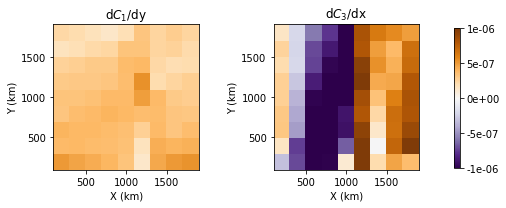

In [6]:
fig, ax = plt.subplots(1,2, figsize=(8,3))

im = ax[0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, dCdy.isel(
    tracer_num=0).sel(Z=-1500, method='nearest') , cmap='PuOr_r', 
               vmin=-1e-6, vmax=1e-6, rasterized=True)
ax[0].set_title('d$C_1$/dy')
ax[0].set_aspect('equal')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')

im = ax[1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, dCdx.isel(
    tracer_num=4).sel(Z=-1500, method='nearest') , cmap='PuOr_r', 
               vmin=-1e-6, vmax=1e-6, rasterized=True)
ax[1].set_title('d$C_3$/dx')
ax[1].set_aspect('equal')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Y (km)')

plt.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax, format='%.0e')
#fig.colorbar(im, ax=ax.ravel().tolist())

#plt.savefig('trac_grads.pdf', dpi=400)

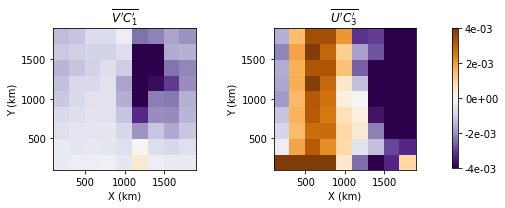

In [7]:
fig, ax = plt.subplots(1,2, figsize=(8,3))

im = ax[0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, VpCp.isel(
    tracer_num=0).sel(Z=-1500, method='nearest') , cmap='PuOr_r', 
               vmin=-4e-3, vmax=4e-3, rasterized=True)
ax[0].set_title('$\overline{V\'C_1\'}$')
ax[0].set_aspect('equal')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')

im =ax[1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, UpCp.isel(
    tracer_num=4).sel(Z=-1500, method='nearest'), cmap='PuOr_r', 
               vmin=-4e-3, vmax=4e-3, rasterized=True)
ax[1].set_title('$\overline{U\'C_3\'}$')
ax[1].set_aspect('equal')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Y (km)')

plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax, format='%.0e')
#fig.colorbar(im, ax=ax.ravel().tolist())

#plt.savefig('trac_fluxes.pdf', dpi=400)

In [8]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)

Ktensor_fast = xr.apply_ufunc(calc_tensor, 
                       UpCp.sel(tracer_num=slice(1,19,2)),
                       VpCp.sel(tracer_num=slice(1,19,2)),
                       WpCp.sel(tracer_num=slice(1,19,2)),
                       dCdx.sel(tracer_num=slice(1,19,2)),
                       dCdy.sel(tracer_num=slice(1,19,2)),
                       dCdz.sel(tracer_num=slice(1,19,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

Ktensor_fast.load() # need to load because we will take transpose and a

CPU times: user 1.01 s, sys: 10.1 ms, total: 1.02 s
Wall time: 1.03 s


In [9]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)

Ktensor_slow = xr.apply_ufunc(calc_tensor, 
                       UpCp.sel(tracer_num=slice(2,20,2)),
                       VpCp.sel(tracer_num=slice(2,20,2)),
                       WpCp.sel(tracer_num=slice(2,20,2)),
                       dCdx.sel(tracer_num=slice(2,20,2)),
                       dCdy.sel(tracer_num=slice(2,20,2)),
                       dCdz.sel(tracer_num=slice(2,20,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

Ktensor_slow.load() # need to load because we will take transpose and a

CPU times: user 768 ms, sys: 9.49 ms, total: 777 ms
Wall time: 764 ms


In [10]:
lam1 = 1/31104000.
lam2 = 1/186624000.

Ktensor_corr = (lam2*Ktensor_fast - lam1*Ktensor_slow)/(lam2 - lam1)

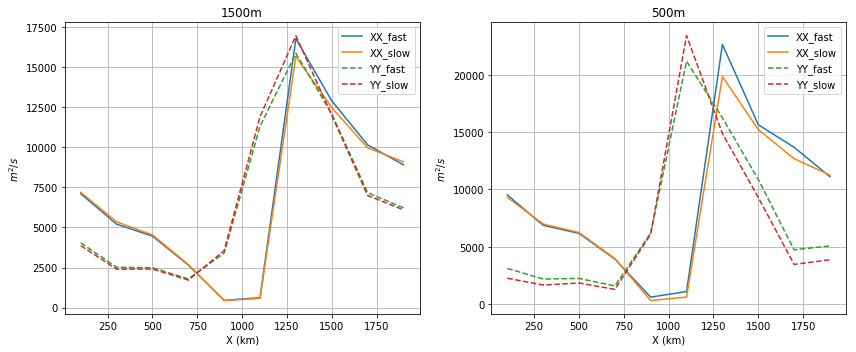

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(Xcoarse/1e3, Ktensor_fast.isel(i=0,j=0).sel(Z=-1500, method='nearest').sel(YCcoarse=1000e3,method='nearest') 
         , label='XX_fast')
plt.plot(Xcoarse/1e3, Ktensor_slow.isel(i=0,j=0).sel(Z=-1500, method='nearest').sel(YCcoarse=1000e3,method='nearest') 
         , label='XX_slow')
#plt.plot(Xcoarse/1e3, Ktensor_all.isel(i=0,j=0).sel(Z=-1500, method='nearest').sel(YCcoarse=1000e3,method='nearest') 
#         , label='XX_all')

plt.plot(Xcoarse/1e3, Ktensor_fast.isel(i=1,j=1).sel(Z=-1500, method='nearest').sel(YCcoarse=1000e3,method='nearest') 
         ,'--',  label='YY_fast')
plt.plot(Xcoarse/1e3, Ktensor_slow.isel(i=1,j=1).sel(Z=-1500, method='nearest').sel(YCcoarse=1000e3,method='nearest') 
         ,'--', label='YY_slow')
#plt.plot(Xcoarse/1e3, Ktensor_all.isel(i=1,j=1).sel(Z=-1500, method='nearest').sel(YCcoarse=1000e3,method='nearest') 
#         ,'--', label='YY_all')
plt.grid()
plt.legend()
plt.title('1500m')
plt.xlabel('X (km)')
plt.ylabel('$m^2/s$')

plt.subplot(122)
plt.plot(Xcoarse/1e3, Ktensor_fast.isel(i=0,j=0).sel(Z=-500, method='nearest').sel(YCcoarse=1000e3,method='nearest') 
         , label='XX_fast')
plt.plot(Xcoarse/1e3, Ktensor_slow.isel(i=0,j=0).sel(Z=-500, method='nearest').sel(YCcoarse=1000e3,method='nearest') 
         , label='XX_slow')
#plt.plot(Xcoarse/1e3, Ktensor_all.isel(i=0,j=0).sel(Z=-500, method='nearest').sel(YCcoarse=1000e3,method='nearest') 
#         , label='XX_all')

plt.plot(Xcoarse/1e3, Ktensor_fast.isel(i=1,j=1).sel(Z=-500, method='nearest').sel(YCcoarse=1000e3,method='nearest') 
         ,'--',  label='YY_fast')
plt.plot(Xcoarse/1e3, Ktensor_slow.isel(i=1,j=1).sel(Z=-500, method='nearest').sel(YCcoarse=1000e3,method='nearest') 
         ,'--', label='YY_slow')
#plt.plot(Xcoarse/1e3, Ktensor_all.isel(i=1,j=1).sel(Z=-500, method='nearest').sel(YCcoarse=1000e3,method='nearest') 
#         ,'--', label='YY_all')
plt.legend()
plt.title('500m')
plt.xlabel('X (km)')
plt.ylabel('$m^2/s$')
plt.grid()
plt.tight_layout()

In [13]:
Xcoarse = dCdx.XCcoarse
Ycoarse = dCdx.YCcoarse
Z = dCdx.Z

In [19]:
font = {'family' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rc('text', usetex=False)

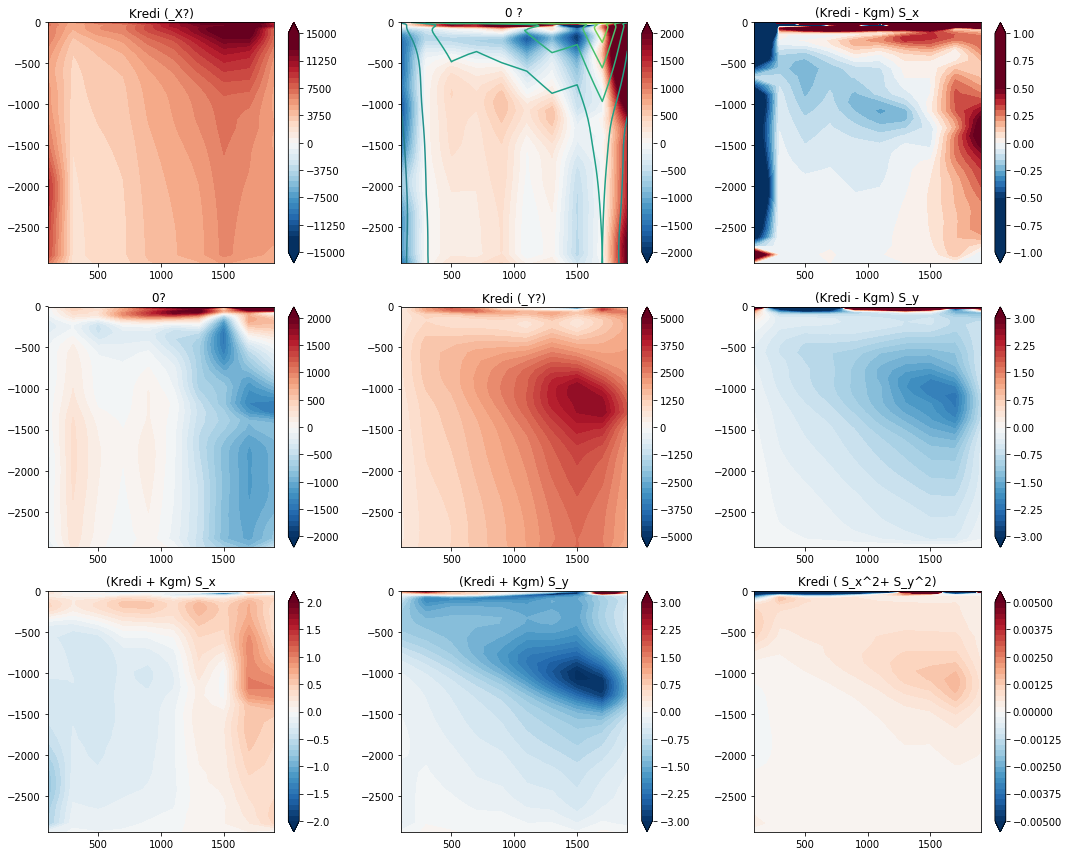

In [15]:
fig , ax = plt.subplots(3,3,figsize=(15,12))

im = ax[0,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=0).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-13000, vmax=13000, levels=np.linspace(-15e3, 15e3, 41), cmap='RdBu_r', extend='both')
fig.colorbar(im , ax = ax[0,0])
ax[0,0].set_title('Kredi (_X?)')

im = ax[0,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=1).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-2000, vmax=2000, levels=np.linspace(-2e3, 2e3, 41), cmap='RdBu_r', extend='both')
fig.colorbar(im , ax = ax[0,1])
ax[0,1].contour(Ycoarse/1e3, Z, Vels_coarse.U.sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), levels=np.linspace(-0.15,0.15,15))
ax[0,1].set_title('0 ?')

im = ax[0,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=2).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-0.5, vmax=0.5, levels=np.linspace(-1, 1, 41), cmap='RdBu_r', extend='both')
fig.colorbar(im , ax = ax[0,2])
ax[0,2].set_title('(Kredi - Kgm) S_x')

##
im = ax[1,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=0).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-2000, vmax=2000, levels=np.linspace(-2e3, 2e3, 41), cmap='RdBu_r', extend='both')
fig.colorbar(im , ax = ax[1,0])
ax[1,0].set_title('0? ')

im = ax[1,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-5000, vmax=5000, levels=np.linspace(-5e3, 5e3, 41), cmap='RdBu_r', extend='both')
fig.colorbar(im , ax = ax[1,1])
ax[1,1].set_title('Kredi (_Y?)')


im = ax[1,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=2).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-3, vmax=3, levels=np.linspace(-3, 3, 41), cmap='RdBu_r',extend='both')
fig.colorbar(im , ax = ax[1,2])
ax[1,2].set_title('(Kredi - Kgm) S_y')


##
im = ax[2,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=0).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r', extend='both')
fig.colorbar(im , ax = ax[2,0])
ax[2,0].set_title('(Kredi + Kgm) S_x')

im = ax[2,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=1).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-3, vmax=3, levels=np.linspace(-3, 3, 41), cmap='RdBu_r', extend='both')
fig.colorbar(im , ax = ax[2,1])
ax[2,1].set_title('(Kredi + Kgm) S_y')

im = ax[2,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=2).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-5e-3, vmax=5e-3, levels=np.linspace(-5e-3, 5e-3, 41), cmap='RdBu_r', extend='both')
fig.colorbar(im , ax = ax[2,2])
ax[2,2].set_title('Kredi ( S_x^2+ S_y^2)')

plt.tight_layout()


In [16]:
Ktensor_corrT = Ktensor_corr.transpose('Z','YCcoarse','XCcoarse','j','i')

ST = 0.5*(Ktensor_corr.data + Ktensor_corrT.data)
AT = 0.5*(Ktensor_corr.data - Ktensor_corrT.data)

ST = xr.DataArray(ST, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)
AT = xr.DataArray(AT, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)

In [17]:
# calculate the eigenvalues and eigenvectors of symmetric part
eigvalsST, eigvecsST = xr.apply_ufunc(eig, ST, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])

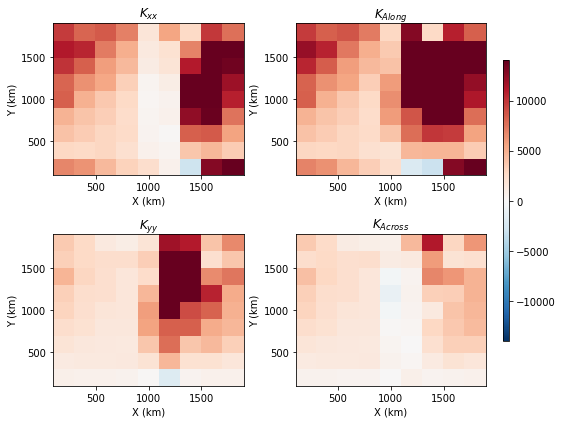

In [21]:
fig, ax = plt.subplots(2,2, figsize=(8,6))
depth =-700
ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, ST.isel(i=0,j=0).sel(Z=depth, method='nearest'),
                  vmin=-14000, vmax=14000, cmap='RdBu_r', rasterized=True)
#ax[0,0].contour(X/1e3, Y/1e3, Model_Tav.ETAtave, levels=np.linspace(-0.5,0.5, 7)
#               , rasterized=True, linewidths=1.)
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Y (km)')
ax[0,0].set_title('$K_{xx}$')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, np.real(eigvalsST).isel(ii=0).sel(Z=depth, method='nearest'),
                  vmin=-14000, vmax=14000, cmap='RdBu_r', rasterized=True)
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Y (km)')
ax[0,1].set_title('$K_{Along}$')

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, ST.isel(i=1,j=1).sel(Z=depth, method='nearest'),
                  vmin=-14000, vmax=14000, cmap='RdBu_r', rasterized=True)
#ax[1,0].contour(X/1e3, Y/1e3, Model_Tav.ETAtave, levels=np.linspace(-0.5,0.5, 7)
#               , rasterized=True, linewidths=1.)
ax[1,0].set_xlabel('X (km)')
ax[1,0].set_ylabel('Y (km)')
ax[1,0].set_title('$K_{yy}$')

im =ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, np.real(eigvalsST).isel(ii=1).sel(Z=depth, method='nearest'),
                  vmin=-14000, vmax=14000, cmap='RdBu_r', rasterized=True)
ax[1,1].set_xlabel('X (km)')
ax[1,1].set_ylabel('Y (km)')
ax[1,1].set_title('$K_{Across}$')

plt.tight_layout()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)

#plt.savefig('Khor_1500m.pdf', dpi=400)

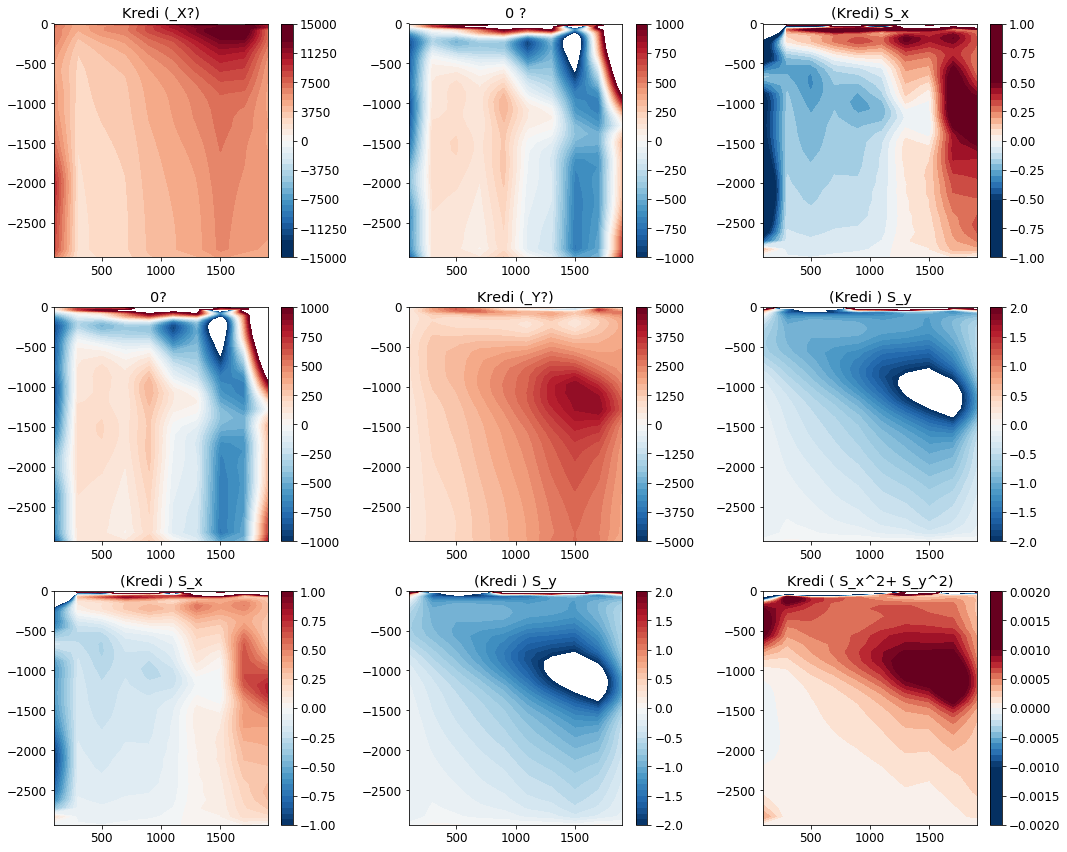

In [29]:
# 
fig , ax = plt.subplots(3,3,figsize=(15,12))

im = ax[0,0].contourf(Ycoarse/1e3, Z, ST.isel(i=0, j=0).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-13000, vmax=13000, levels=np.linspace(-15e3, 15e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,0])
ax[0,0].set_title('Kredi (_X?)')

im = ax[0,1].contourf(Ycoarse/1e3, Z, ST.isel(i=0, j=1).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,1])
ax[0,1].set_title('0 ?')

im = ax[0,2].contourf(Ycoarse/1e3, Z, ST.isel(i=0, j=2).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-0.5, vmax=0.5, levels=np.linspace(-1, 1, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,2])
ax[0,2].set_title('(Kredi) S_x')

##
im = ax[1,0].contourf(Ycoarse/1e3, Z, ST.isel(i=1, j=0).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,0])
ax[1,0].set_title('0? ')

im = ax[1,1].contourf(Ycoarse/1e3, Z, ST.isel(i=1, j=1).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-5000, vmax=5000, levels=np.linspace(-5e3, 5e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,1])
ax[1,1].set_title('Kredi (_Y?)')


im = ax[1,2].contourf(Ycoarse/1e3, Z, ST.isel(i=1, j=2).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,2])
ax[1,2].set_title('(Kredi ) S_y')

##
im = ax[2,0].contourf(Ycoarse/1e3, Z, ST.isel(i=2, j=0).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-1, vmax=1, levels=np.linspace(-1, 1, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,0])
ax[2,0].set_title('(Kredi ) S_x')

im = ax[2,1].contourf(Ycoarse/1e3, Z, ST.isel(i=2, j=1).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,1])
ax[2,1].set_title('(Kredi ) S_y')

im = ax[2,2].contourf(Ycoarse/1e3, Z, ST.isel(i=2, j=2).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-1e-3, vmax=1e-3, levels=np.linspace(-2e-3, 2e-3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,2])
ax[2,2].set_title('Kredi ( S_x^2+ S_y^2)')

plt.tight_layout()

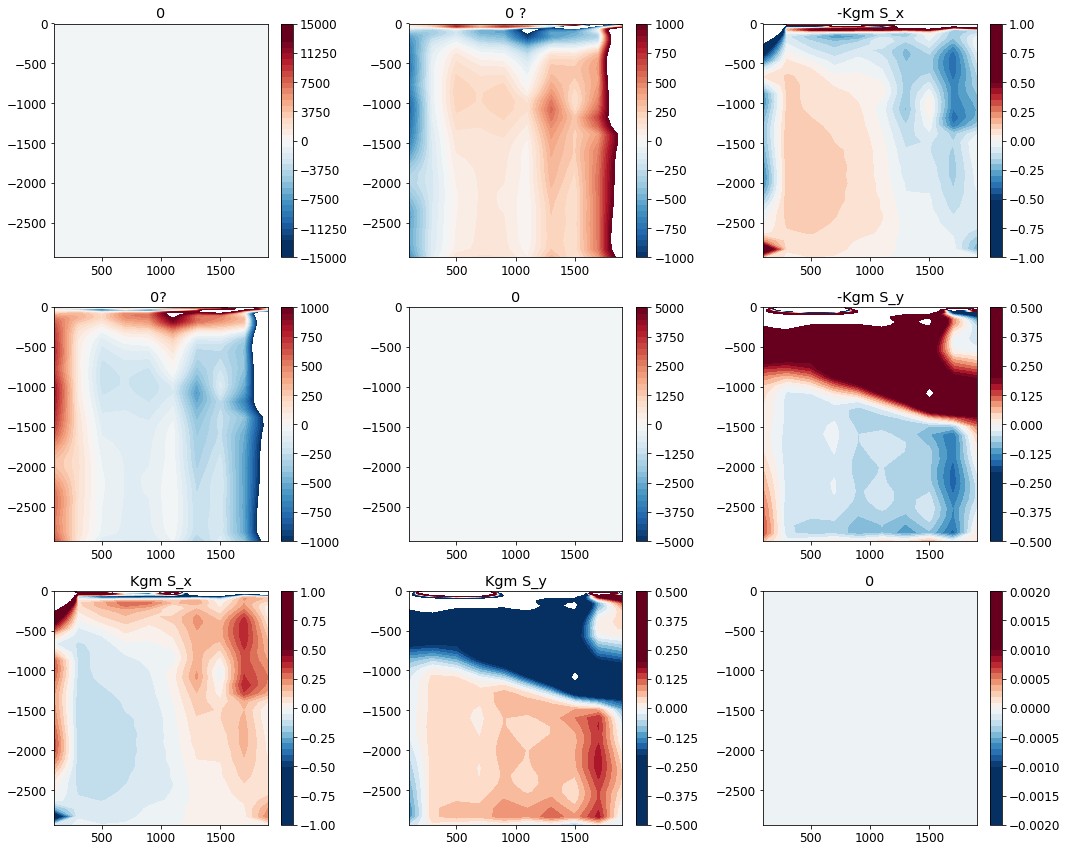

In [32]:
# 
fig , ax = plt.subplots(3,3,figsize=(15,12))

im = ax[0,0].contourf(Ycoarse/1e3, Z, AT.isel(i=0, j=0).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-13000, vmax=13000, levels=np.linspace(-15e3, 15e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,0])
ax[0,0].set_title('0')

im = ax[0,1].contourf(Ycoarse/1e3, Z, AT.isel(i=0, j=1).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,1])
ax[0,1].set_title('0 ?')

im = ax[0,2].contourf(Ycoarse/1e3, Z, AT.isel(i=0, j=2).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-0.5, vmax=0.5, levels=np.linspace(-1, 1, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,2])
ax[0,2].set_title('-Kgm S_x')

##
im = ax[1,0].contourf(Ycoarse/1e3, Z, AT.isel(i=1, j=0).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,0])
ax[1,0].set_title('0? ')

im = ax[1,1].contourf(Ycoarse/1e3, Z, AT.isel(i=1, j=1).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-5000, vmax=5000, levels=np.linspace(-5e3, 5e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,1])
ax[1,1].set_title('0')


im = ax[1,2].contourf(Ycoarse/1e3, Z, AT.isel(i=1, j=2).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-0.2, vmax=0.2, levels=np.linspace(-0.5, 0.5, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,2])
ax[1,2].set_title('-Kgm S_y')


##
im = ax[2,0].contourf(Ycoarse/1e3, Z, AT.isel(i=2, j=0).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-0.5, vmax=0.5, levels=np.linspace(-1, 1, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,0])
ax[2,0].set_title('Kgm S_x')

im = ax[2,1].contourf(Ycoarse/1e3, Z, AT.isel(i=2, j=1).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-0.2, vmax=0.2, levels=np.linspace(-0.5, 0.5, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,1])
ax[2,1].set_title('Kgm S_y')

im = ax[2,2].contourf(Ycoarse/1e3, Z, AT.isel(i=2, j=2).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'), 
               vmin=-1e-3, vmax=1e-3, levels=np.linspace(-2e-3, 2e-3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,2])
ax[2,2].set_title('0')

plt.tight_layout()

In [24]:
# Calc slopes etc.
T_coarse = xr.open_dataset('T_coarse_200km')

In [33]:
T_coarse['Siso_X'] = - T_coarse['T_X']/ T_coarse['T_Z']
T_coarse['Siso_Y'] = - T_coarse['T_Y']/ T_coarse['T_Z']

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


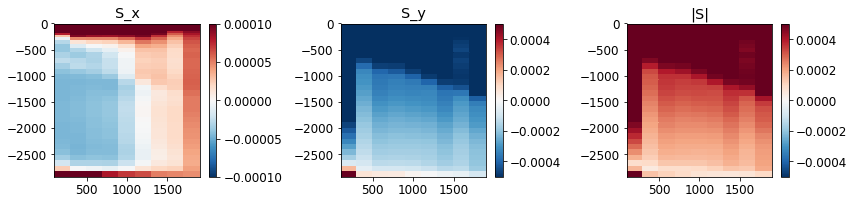

In [36]:
fig, ax = plt.subplots(1,3,figsize=(12,3))

im = ax[0].pcolormesh(Ycoarse/1e3, Z, T_coarse.Siso_X.sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'),
                      vmin=-1e-4, vmax=1e-4, cmap='RdBu_r')
fig.colorbar(im, ax = ax[0])
ax[0].set_title('S_x')

im = ax[1].pcolormesh(Ycoarse/1e3, Z, T_coarse.Siso_Y.sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'),
                      vmin=-5e-4, vmax=5e-4, cmap='RdBu_r')
fig.colorbar(im, ax = ax[1])
ax[1].set_title('S_y')

im = ax[2].pcolormesh(Ycoarse/1e3, Z, ((T_coarse.Siso_Y**2 + T_coarse.Siso_X**2)**0.5  ).sel(XCcoarse=slice(0,800e3)).mean('XCcoarse'),
                      vmin=-5e-4, vmax=5e-4, cmap='RdBu_r')
fig.colorbar(im, ax = ax[2])
ax[2].set_title('|S|')

plt.tight_layout()

In [57]:
diff_tensor = xr.Dataset()
diff_tensor['Kfast'] = Ktensor_fast
diff_tensor['Kslow'] = Ktensor_slow
diff_tensor['Kcorr'] = Ktensor_corr
diff_tensor['ST'] = ST
diff_tensor['AT'] = AT
diff_tensor['eigvalsST'] = np.real(eigvalsST)
diff_tensor['eigvecsST'] = eigvecsST

In [59]:
diff_tensor.to_netcdf('./outputs_ncfiles/diff_tensor_'+str(int(Lcoarse//1e3))+'km.nc')